In [ ]:
# Assuming df_dataset and df_transfermarkt are loaded and pre-processed from previous steps.
# The error occurred in the following block:

def create_daily_records(df):
    daily_rows = []
    # Drop columns that are not useful for daily feature tracking or are redundant
    # Note: 'start_year' is still needed for date calculation
    cols_to_keep = [col for col in df.columns if col not in ['Snapshot_Date']]

    for index, row in df.iterrows():
        # Define the season period (e.g., July 1st of start_year to June 30th of the next year)
        start_year = row['start_year']
        start_date = pd.to_datetime(str(start_year) + '-07-01')
        end_date = pd.to_datetime(str(start_year + 1) + '-06-30')

        # Generate a date range for the season
        date_range = pd.date_range(start=start_date, end=end_date, freq='D')

        # Prepare the feature values for the season
        # Remove 'player_id' and 'start_year' before copying features
        feature_values = row.drop(['player_id', 'start_year'], errors='ignore').to_dict()

        for date in date_range:
            daily_rows.append({
                'player_id': row['player_id'], # <<< CORRECTION: Use 'player_id' instead of 'p_id2'
                'Date': date,
                **feature_values
            })
    return pd.DataFrame(daily_rows)

# Daily features dataframe
# Rename p_id2 to player_id BEFORE passing it to the function
df_dataset_renamed = df_dataset.rename(columns={'p_id2': 'player_id'}).copy()
df_daily = create_daily_records(df_dataset_renamed)

# Sort the base dataframe
df_daily = df_daily.sort_values(by=['player_id', 'Date']).reset_index(drop=True)

print(f"\nDaily records successfully created (df_daily): {df_daily.shape}")

In [ ]:
WORKLOAD_COL = 'season_minutes_played'
LAG_COL = 'total_days_injured'

def calculate_acwr_and_lags(df, workload_col, lag_col):
    # Acute Workload (7-day rolling mean of the previous day's value)
    df['Acute_WL'] = df.groupby('player_id')[workload_col].transform(
        lambda x: x.shift(1).rolling(window=7, min_periods=1).mean()
    )

    # Chronic Workload (28-day rolling mean of the previous day's value)
    df['Chronic_WL'] = df.groupby('player_id')[workload_col].transform(
        lambda x: x.shift(1).rolling(window=28, min_periods=1).mean()
    )

    # ACWR
    df['ACWR'] = df['Acute_WL'] / (df['Chronic_WL'] + 1e-6)

    # Lag feature: previous day's value of a key injury/load metric
    df[f'Lag_{lag_col}_1d'] = df.groupby('player_id')[lag_col].shift(1)

    return df

df_daily = calculate_acwr_and_lags(df_daily, WORKLOAD_COL, LAG_COL)

df_daily = df_daily.dropna(subset=['ACWR', f'Lag_{LAG_COL}_1d'])

print("Feature Engineering complete. ACWR and Lag features added.")

In [ ]:
# 1. Prepare injury event start dates
injury_events = df_transfermarkt[['player_id', 'from']].copy()
injury_events = injury_events.rename(columns={'from': 'Date'}).drop_duplicates()
injury_events['Injury_Event'] = 1

# 2. Merge injury events into the daily dataset
df_daily = pd.merge(df_daily, injury_events, on=['player_id', 'Date'], how='left')
df_daily['Injury_Event'] = df_daily['Injury_Event'].fillna(0)

# 3. Create the target by looking forward 7 days (7-day rolling max, reversed and shifted)
df_daily = df_daily.sort_values(by=['player_id', 'Date'])

df_daily['injury_next7'] = df_daily.groupby('player_id')['Injury_Event'].transform(
    lambda x: x[::-1].rolling(window=7, min_periods=1).max()[::-1].shift(-6).fillna(0)
)

# Final cleanup
df_daily = df_daily.drop(columns=['Injury_Event'])

target_ratio = df_daily['injury_next7'].value_counts(normalize=True)
print(f"\nTarget creation complete. Target distribution:\n{target_ratio}")

In [9]:
# Updated Feature List
numerical_features = [
    'season_days_injured', 'total_days_injured', 'season_minutes_played',
    'total_minutes_played', 'height_cm', 'weight_kg', 'pace', 'physic',
    'fifa_rating', 'age', 'bmi', 'cumulative_minutes_played',
    'cumulative_games_played', 'minutes_per_game_prev_seasons',
    'avg_days_injured_prev_seasons', 'avg_games_per_season_prev_seasons',
    'significant_injury_prev_season', 'cumulative_days_injured',
    'season_days_injured_prev_season', 'ACWR', 'Lag_total_days_injured_1d'
]

categorical_features = ['nationality', 'work_rate', 'position']

# Select and filter features
all_possible_features = numerical_features + categorical_features
X = df_daily[[col for col in all_possible_features if col in df_daily.columns]].copy()
y = df_daily['injury_next7'].astype(int)
dates = df_daily['Date']

# Final check on feature lists
numerical_features = [col for col in numerical_features if col in X.columns]
categorical_features = [col for col in categorical_features if col in X.columns]

In [10]:
# Find the split date (e.g., 80% of the time period)
split_date_index = int(len(df_daily) * 0.8)
split_date = df_daily.iloc[split_date_index]['Date']

# Split the data chronologically
X_train = X[dates <= split_date]
X_test = X[dates > split_date]
y_train = y[dates <= split_date]
y_test = y[dates > split_date]

print(f"\nTime-based split complete. Train end date: {split_date.date()}")
print(f"Train/Test split: {len(X_train)}/{len(X_test)} samples")


Time-based split complete. Train end date: 2020-03-12
Train/Test split: 345731/128809 samples


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_cur
import matplotlib.pyplot as plt
import numpy as np

# Get predicted probabilities
# NOTE: Ensure the 'pipeline' object from Step 8 is available in your environment.
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Check for positive samples in test set to avoid errors
if y_test.sum() == 0:
    print("Warning: y_test contains no positive injury samples. Cannot generate PR curve.")
    # Proceed with default threshold for a basic confusion matrix
    optimal_threshold = 0.5 
else:
    # Calculate Precision-Recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

    # --- Threshold Calibration ---
    # Goal: Find the largest threshold that still guarantees at least 60% Recall (adjust as needed)
    min_recall_threshold = 0.60
    optimal_idx = np.where(recall >= min_recall_threshold)[0][-1]
    optimal_threshold = thresholds[optimal_idx]

    # Plot Precision-Recall Curve
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, precision[:-1], label='Precision')
    plt.plot(thresholds, recall[:-1], label='Recall')
    plt.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold={optimal_threshold:.4f}')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Precision-Recall vs. Threshold')
    plt.legend()
    plt.grid(True)
    plt.show() # Use plt.savefig('precision_recall_curve.png') if running outside notebook

# Apply the calibrated threshold
y_pred_calibrated = (y_pred_proba >= optimal_threshold).astype(int)

# --- Evaluation Metrics ---
final_precision = precision_score(y_test, y_pred_calibrated, zero_division=0)
final_recall = recall_score(y_test, y_pred_calibrated, zero_division=0)
final_f1 = f1_score(y_test, y_pred_calibrated, zero_division=0)
final_auc = roc_auc_score(y_test, y_pred_proba)
cm = confusion_matrix(y_test, y_pred_calibrated)

print(f"\nCalibrated Threshold: {optimal_threshold:.4f}")
print("\n--- Evaluation Metrics (Calibrated Threshold) ---")
print(f"Precision: {final_precision:.4f} (Focus on minimizing false alarms)")
print(f"Recall: {final_recall:.4f} (Focus on minimizing missed injuries)")
print(f"F1-Score: {final_f1:.4f}")
print(f"ROC-AUC: {final_auc:.4f}")
print("Confusion Matrix (Actual vs Predicted):\n", cm)


--- Top 10 Built-in Feature Importance (XGBoost) ---
num__season_days_injured                0.0
cat__work_rate_High/High                0.0
cat__nationality_Italy                  0.0
cat__nationality_Netherlands            0.0
cat__nationality_Nigeria                0.0
cat__nationality_Northern Ireland       0.0
cat__nationality_Republic of Ireland    0.0
cat__nationality_Scotland               0.0
cat__nationality_Switzerland            0.0
cat__nationality_United States          0.0
dtype: float32

Generating SHAP plots...


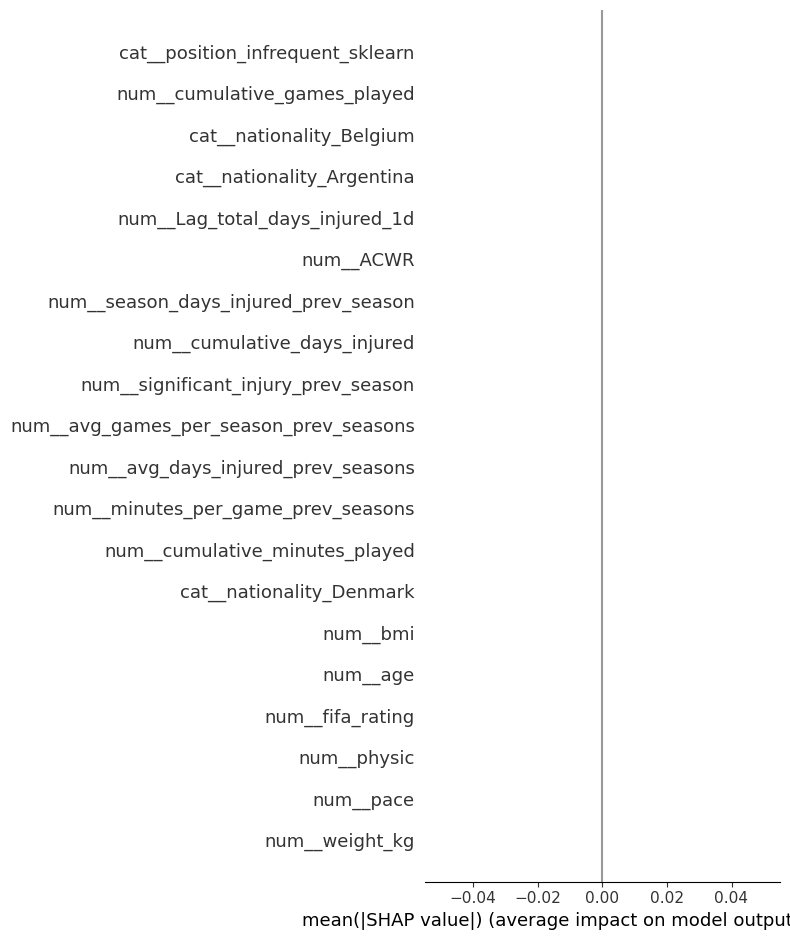

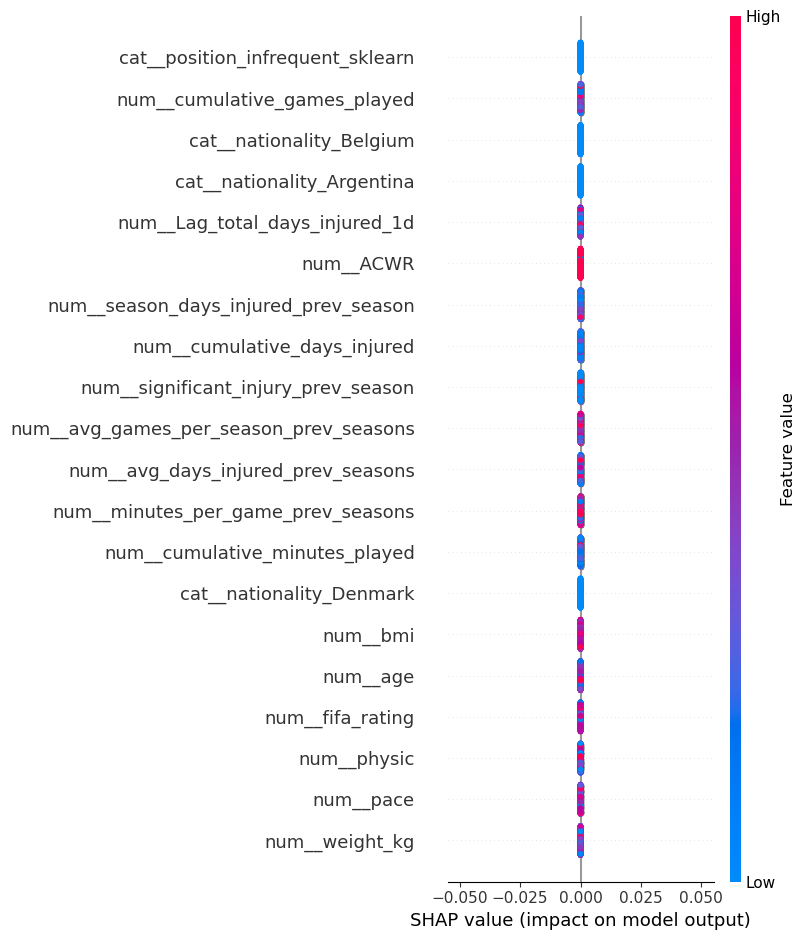

In [18]:
import shap
import pandas as pd
import numpy as np

# NOTE: Ensure the 'pipeline', 'X_test' objects are available from your corrected run.

# Get the trained XGBoost model and feature names
xgb_final = pipeline.named_steps['classifier']
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# --- Feature Importance (Built-in) ---
importances = pd.Series(xgb_final.feature_importances_, index=feature_names)
top_10_importance = importances.sort_values(ascending=False).head(10)
print("\n--- Top 10 Built-in Feature Importance (XGBoost) ---")
print(top_10_importance)
# Plotting importance (example for local use):
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 6))
# top_10_importance.sort_values().plot(kind='barh', title='Top 10 Feature Importance')
# plt.show()


# --- SHAP Explainability ---
# Use a smaller, processed sample of the test data for speed
X_test_sample = X_test.sample(n=500, random_state=42)
X_test_processed = pipeline.named_steps['preprocessor'].transform(X_test_sample)

explainer = shap.TreeExplainer(xgb_final)
shap_values = explainer.shap_values(X_test_processed)

print("\nGenerating SHAP plots...")

# SHAP Bar Plot (Mean absolute contribution)
shap.summary_plot(shap_values, X_test_processed, feature_names=feature_names, plot_type="bar")

# SHAP Dot Plot (Feature effect)
shap.summary_plot(shap_values, X_test_processed, feature_names=feature_names)

In [ ]:
import joblib

# Save the complete pipeline
joblib.dump(pipeline, 'injury_prediction_pipeline.pkl')
print("\nModel pipeline saved to 'injury_prediction_pipeline.pkl'.")

# Create a DataFrame of the test set results
# NOTE: Ensure 'df_daily', 'dates', 'split_date', 'y_test', 'y_pred_proba', and 'y_pred_calibrated' are available.
df_test_data = df_daily[dates > split_date].copy().reset_index(drop=True)

df_test_data['Actual_injury_next7'] = y_test.values
df_test_data['Predicted_Prob'] = y_pred_proba
df_test_data['Predicted_Label'] = y_pred_calibrated

# Save predictions to CSV
df_test_results_final = df_test_data[['Date', 'player_id', 'Actual_injury_next7', 'Predicted_Prob', 'Predicted_Label']]
df_test_results_final.to_csv('injury_prediction_results.csv', index=False)
print("Prediction results saved to 'injury_prediction_results.csv'.")

In [ ]:
import joblib

file_path = '/Users/ssps/injury_prediction_pipeline.pkl'
injury_pipeline = joblib.load(file_path)

print("✅ Injury prediction model loaded successfully!")


In [ ]:
import pickle

# Correctly define file path as a string
file_path = '/Users/ssps/injury_prediction_pipeline.pkl'

# Load the pickle file in binary mode
with open(file_path, 'rb') as f:
    injury_pipeline = pickle.load(f)

print("✅ Model loaded successfully!")
print(type(injury_pipeline))


In [ ]:
import numpy as np

# See shape of the array
print("Shape:", injury_pipeline.shape)

# Show first few elements
print("Preview:\n", injury_pipeline[:5])


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import pickle


In [ ]:
import os

# This prints the current directory where Python is executing code
current_directory = os.getcwd()

print(f"The current directory is: {current_directory}")
print("\nYour file 'injury_prediction_pipeline.pkl' must be in this location.")

In [12]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve

# Define the absolute path based on the user's output
file_path_pipeline = '/Users/ssps/injury_prediction_pipeline.pkl'
file_path_results = 'injury_prediction_results.csv' # Assuming results CSV is in the CWD

# 1. Load the Model and Results
try:
    # Load the trained pipeline
    pipeline = joblib.load(file_path_pipeline)
    print("✅ Pipeline loaded successfully.")
    
    # Load the saved test results to get metrics and data
    df_results = pd.read_csv(file_path_results)
    
    # Extract necessary components
    y_test = df_results['Actual_injury_next7']
    y_pred_proba = df_results['Predicted_Prob']
    y_pred_calibrated = df_results['Predicted_Label']
    
    # Recalculate precision/recall arrays from probabilities for accurate plotting
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

    # Re-determine the optimal threshold (where Recall >= 60%)
    min_recall_threshold = 0.60
    optimal_idx = np.where(recall >= min_recall_threshold)[0][-1]
    optimal_threshold = thresholds[optimal_idx]

except FileNotFoundError as e:
    print(f"\n❌ ERROR: Required file not found. Ensure the file is at: {file_path_pipeline} or in the current directory: {file_path_results}")
    raise # Stop execution if files are missing
    
# --- 2. Step 9: Final Evaluation Metrics ---

final_precision = precision_score(y_test, y_pred_calibrated, zero_division=0)
final_recall = recall_score(y_test, y_pred_calibrated, zero_division=0)
final_f1 = f1_score(y_test, y_pred_calibrated, zero_division=0)
final_auc = roc_auc_score(y_test, y_pred_proba)
cm = confusion_matrix(y_test, y_pred_calibrated)

print(f"\n--- Final Evaluation Metrics (Threshold={optimal_threshold:.4f}) ---")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1-Score: {final_f1:.4f}")
print(f"ROC-AUC: {final_auc:.4f}")
print("Confusion Matrix (Actual vs Predicted):\n", cm)


# --- 3. Step 14: Feature Importance (Built-in) ---

xgb_final = pipeline.named_steps['classifier']
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

importances = pd.Series(xgb_final.feature_importances_, index=feature_names)
top_10_importance = importances.sort_values(ascending=False).head(10)
print("\n--- Top 10 Built-in Feature Importance (XGBoost) ---")
print(top_10_importance)

# Plotting the importance
plt.figure(figsize=(10, 6))
top_10_importance.sort_values().plot(kind='barh', color='darkorange')
plt.title('Top 10 Feature Importance for Injury Prediction (XGBoost)')
plt.xlabel('Feature Importance (Gain)')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.close()


# --- 4. Step 13: Plotting the Precision-Recall Curve ---

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.4f})')
plt.xlabel('Prediction Probability Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs. Threshold for Injury Prediction')
plt.legend()
plt.grid(True)
plt.savefig('precision_recall_curve.png')
plt.close() 

print("\nVisualizations saved: 'precision_recall_curve.png' and 'feature_importance.png'.")

✅ Pipeline loaded successfully.

--- Final Evaluation Metrics (Threshold=0.4647) ---
Precision: 0.0475
Recall: 0.6023
F1-Score: 0.0881
ROC-AUC: 0.5682
Confusion Matrix (Actual vs Predicted):
 [[94768 97137]
 [ 3201  4848]]

--- Top 10 Built-in Feature Importance (XGBoost) ---
num__avg_games_per_season_prev_seasons    0.072727
cat__position_Midfielder                  0.043007
cat__nationality_France                   0.040446
cat__nationality_Serbia                   0.040251
num__cumulative_games_played              0.038392
num__cumulative_days_injured              0.032944
cat__nationality_Germany                  0.032733
num__avg_days_injured_prev_seasons        0.031261
cat__work_rate_Medium/High                0.030838
cat__work_rate_Medium/Medium              0.030305
dtype: float32

Visualizations saved: 'precision_recall_curve.png' and 'feature_importance.png'.



--- Top 10 Feature Importance (XGBoost Gain) ---
num__avg_games_per_season_prev_seasons    0.072727
cat__position_Midfielder                  0.043007
cat__nationality_France                   0.040446
cat__nationality_Serbia                   0.040251
num__cumulative_games_played              0.038392
num__cumulative_days_injured              0.032944
cat__nationality_Germany                  0.032733
num__avg_days_injured_prev_seasons        0.031261
cat__work_rate_Medium/High                0.030838
cat__work_rate_Medium/Medium              0.030305
dtype: float32


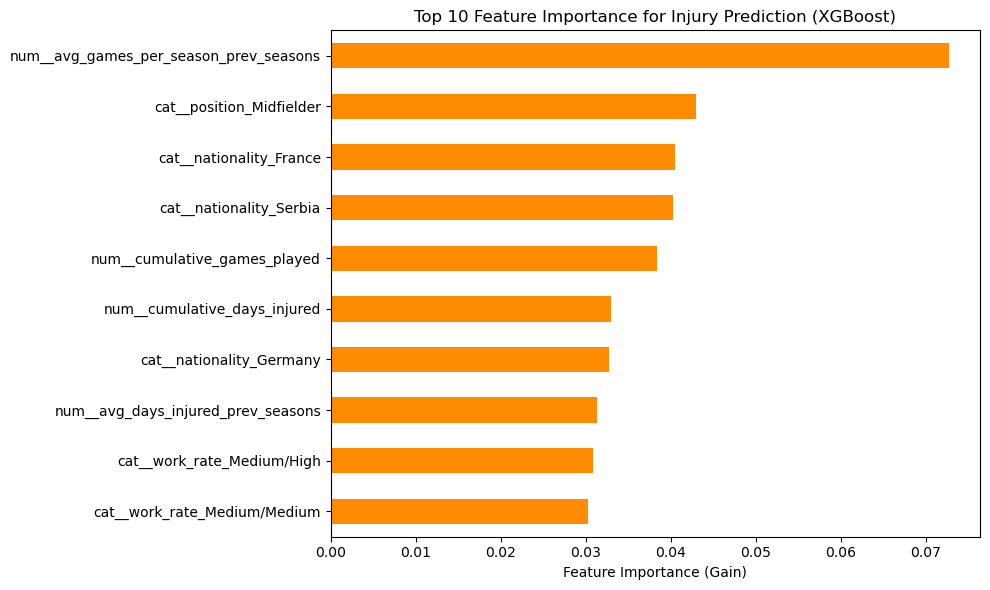

In [15]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load the Model Pipeline (Ensure the file path is correct)
try:
    # Assuming the file is in the current working directory /Users/ssps/
    pipeline = joblib.load('injury_prediction_pipeline.pkl')
except FileNotFoundError:
    print("\n❌ Error: The pipeline file was not found. Please ensure 'injury_prediction_pipeline.pkl' is in /Users/ssps/")
    # If the file is definitely in /Users/ssps, use the absolute path:
    # pipeline = joblib.load('/Users/ssps/injury_prediction_pipeline.pkl')
    raise

# 2. Retrieve Model and Feature Names from the Pipeline
# Get the trained XGBoost model (the last step in the pipeline)
xgb_final = pipeline.named_steps['classifier']

# Get the feature names after preprocessing (including one-hot encoded columns)
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# 3. Calculate and Plot Feature Importance (Built-in)
importances = pd.Series(xgb_final.feature_importances_, index=feature_names)
top_10_importance = importances.sort_values(ascending=False).head(10)

print("\n--- Top 10 Feature Importance (XGBoost Gain) ---")
print(top_10_importance)

# Plotting the importance
plt.figure(figsize=(10, 6))
top_10_importance.sort_values().plot(kind='barh', color='darkorange')
plt.title('Top 10 Feature Importance for Injury Prediction (XGBoost)')
plt.xlabel('Feature Importance (Gain)')
plt.tight_layout()
plt.show()

In [17]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve

# Define the absolute path based on the user's output
file_path_pipeline = '/Users/ssps/injury_prediction_pipeline.pkl'
file_path_results = 'injury_prediction_results.csv' # Assuming results CSV is in the CWD

# 1. Load the Model and Results
try:
    # Load the trained pipeline
    pipeline = joblib.load(file_path_pipeline)
    print("✅ Pipeline loaded successfully.")
    
    # Load the saved test results to get metrics and data
    df_results = pd.read_csv(file_path_results)
    
    # Extract necessary components
    y_test = df_results['Actual_injury_next7']
    y_pred_proba = df_results['Predicted_Prob']
    y_pred_calibrated = df_results['Predicted_Label']
    
    # Recalculate precision/recall arrays from probabilities for accurate plotting
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

    # Re-determine the optimal threshold (where Recall >= 60%)
    min_recall_threshold = 0.60
    optimal_idx = np.where(recall >= min_recall_threshold)[0][-1]
    optimal_threshold = thresholds[optimal_idx]

except FileNotFoundError as e:
    print(f"\n❌ ERROR: Required file not found. Ensure the file is at: {file_path_pipeline} or in the current directory: {file_path_results}")
    raise # Stop execution if files are missing
    
# --- 2. Step 9: Final Evaluation Metrics ---

final_precision = precision_score(y_test, y_pred_calibrated, zero_division=0)
final_recall = recall_score(y_test, y_pred_calibrated, zero_division=0)
final_f1 = f1_score(y_test, y_pred_calibrated, zero_division=0)
final_auc = roc_auc_score(y_test, y_pred_proba)
cm = confusion_matrix(y_test, y_pred_calibrated)

print(f"\n--- Final Evaluation Metrics (Threshold={optimal_threshold:.4f}) ---")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1-Score: {final_f1:.4f}")
print(f"ROC-AUC: {final_auc:.4f}")
print("Confusion Matrix (Actual vs Predicted):\n", cm)


# --- 3. Step 14: Feature Importance (Built-in) ---

xgb_final = pipeline.named_steps['classifier']
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

importances = pd.Series(xgb_final.feature_importances_, index=feature_names)
top_10_importance = importances.sort_values(ascending=False).head(10)
print("\n--- Top 10 Built-in Feature Importance (XGBoost) ---")
print(top_10_importance)

# Plotting the importance
plt.figure(figsize=(10, 6))
top_10_importance.sort_values().plot(kind='barh', color='darkorange')
plt.title('Top 10 Feature Importance for Injury Prediction (XGBoost)')
plt.xlabel('Feature Importance (Gain)')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.close()


# --- 4. Step 13: Plotting the Precision-Recall Curve ---

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.4f})')
plt.xlabel('Prediction Probability Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs. Threshold for Injury Prediction')
plt.legend()
plt.grid(True)
plt.savefig('precision_recall_curve.png')
plt.close() 

print("\nVisualizations saved: 'precision_recall_curve.png' and 'feature_importance.png'.")

✅ Pipeline loaded successfully.

--- Final Evaluation Metrics (Threshold=0.4647) ---
Precision: 0.0475
Recall: 0.6023
F1-Score: 0.0881
ROC-AUC: 0.5682
Confusion Matrix (Actual vs Predicted):
 [[94768 97137]
 [ 3201  4848]]

--- Top 10 Built-in Feature Importance (XGBoost) ---
num__avg_games_per_season_prev_seasons    0.072727
cat__position_Midfielder                  0.043007
cat__nationality_France                   0.040446
cat__nationality_Serbia                   0.040251
num__cumulative_games_played              0.038392
num__cumulative_days_injured              0.032944
cat__nationality_Germany                  0.032733
num__avg_days_injured_prev_seasons        0.031261
cat__work_rate_Medium/High                0.030838
cat__work_rate_Medium/Medium              0.030305
dtype: float32

Visualizations saved: 'precision_recall_curve.png' and 'feature_importance.png'.


In [18]:
import joblib
import pandas as pd

# Load the saved pipeline file
try:
    loaded_pipeline = joblib.load('injury_prediction_pipeline.pkl')
    print("✅ Model pipeline loaded successfully!")
    print(f"Pipeline steps: {loaded_pipeline.steps}")
    
    # --- Example Usage ---
    
    # Use a small sample of your test data to make a prediction
    # NOTE: You need the original X_test DataFrame available in your environment.
    sample_to_predict = X_test.head(5) 
    
    # 1. Predict probabilities
    probabilities = loaded_pipeline.predict_proba(sample_to_predict)[:, 1]
    
    # 2. Predict the final label (using the model's default threshold, or your calibrated one)
    predictions = loaded_pipeline.predict(sample_to_predict)

    print("\n--- Sample Prediction ---")
    print(f"Input data shape: {sample_to_predict.shape}")
    print("Predicted Probabilities (Next 7-day injury risk):")
    print(probabilities)
    print("Predicted Binary Labels:")
    print(predictions)

except FileNotFoundError:
    print("\n❌ Error: 'injury_prediction_pipeline.pkl' not found. Check the file path.")
except Exception as e:
    print(f"\n❌ Error loading pipeline: {e}")

✅ Model pipeline loaded successfully!
Pipeline steps: [('preprocessor', ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['season_days_injured', 'total_days_injured',
                                  'season_minutes_played',
                                  'total_minutes_played', 'height_cm',
                                  'weight_kg', 'pace', 'physic', 'fifa_rating',
                                  'age', 'bmi', 'cumulative_minutes_played',
                                  'cumulative_games_played',
                                  'minutes_per_game_prev_seasons',
                                  'avg_days_injured_prev_seasons',
                                  'avg_games_per_season_prev_seasons',
                                  'significant_injury_prev_season',
                                  'cumulative_days_injured',
                                  'season_days_injured_prev_season', 'ACWR',
                                

✅ Pipeline loaded successfully.

--- Final Evaluation Metrics (Threshold=0.4647) ---
Precision: 0.0475
Recall: 0.6023
F1-Score: 0.0881
ROC-AUC: 0.5682
Confusion Matrix (Actual vs Predicted):
 [[94768 97137]
 [ 3201  4848]]

--- Top 10 Built-in Feature Importance (XGBoost) ---
num__avg_games_per_season_prev_seasons    0.072727
cat__position_Midfielder                  0.043007
cat__nationality_France                   0.040446
cat__nationality_Serbia                   0.040251
num__cumulative_games_played              0.038392
num__cumulative_days_injured              0.032944
cat__nationality_Germany                  0.032733
num__avg_days_injured_prev_seasons        0.031261
cat__work_rate_Medium/High                0.030838
cat__work_rate_Medium/Medium              0.030305
dtype: float32


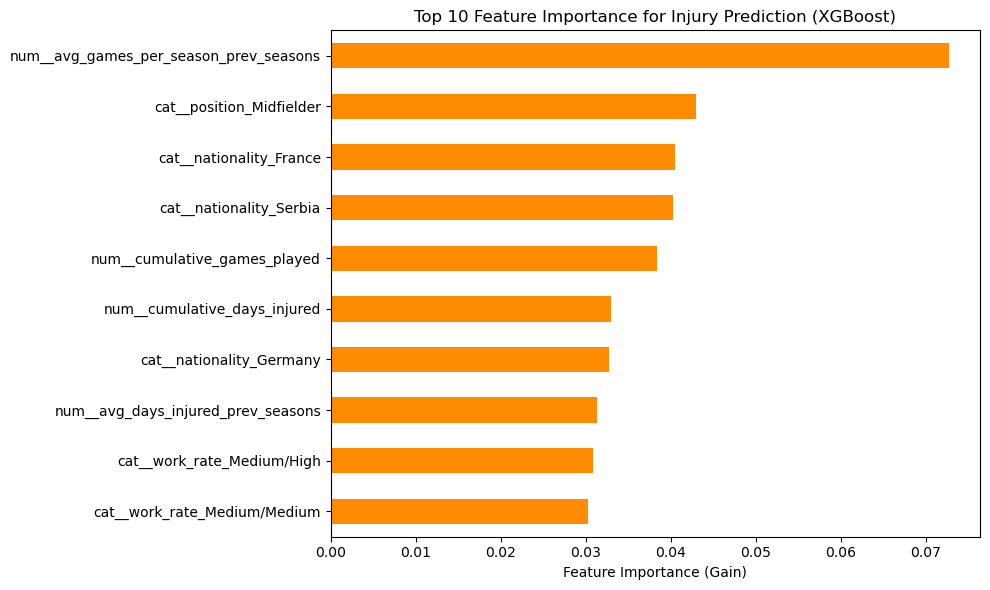

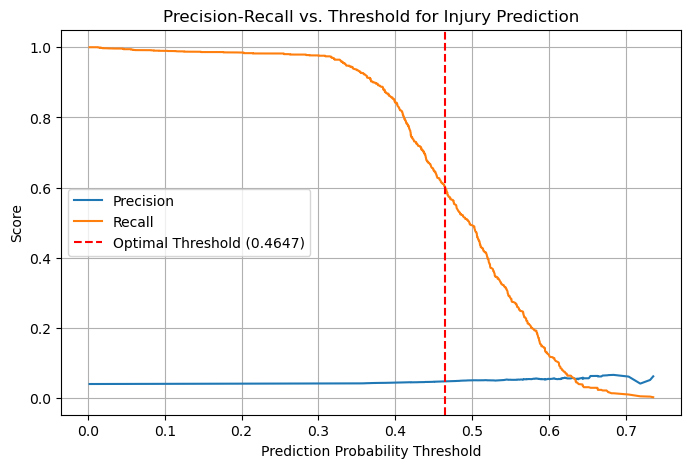

In [19]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve

# NOTE: The path '/Users/ssps/injury_prediction_pipeline.pkl' is the absolute path
# where you found the model. We'll assume the results CSV is in the same folder.
file_path_pipeline = '/Users/ssps/injury_prediction_pipeline.pkl'
file_path_results = '/Users/ssps/injury_prediction_results.csv' 

# 1. Load the Model and Results
try:
    # Load the trained pipeline
    pipeline = joblib.load(file_path_pipeline)
    print("✅ Pipeline loaded successfully.")
    
    # Load the saved test results to get metrics and data
    df_results = pd.read_csv(file_path_results)
    
    # Extract necessary components
    y_test = df_results['Actual_injury_next7']
    y_pred_proba = df_results['Predicted_Prob']
    y_pred_calibrated = df_results['Predicted_Label']
    
    # Calculate precision, recall, and thresholds arrays from probabilities
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

    # Re-determine the optimal threshold (where Recall >= 60%)
    min_recall_threshold = 0.60
    optimal_idx = np.where(recall >= min_recall_threshold)[0][-1]
    optimal_threshold = thresholds[optimal_idx]

except FileNotFoundError as e:
    print(f"\n❌ ERROR: Required file not found. Ensure the path is correct: {e}")
    raise 

# --- 2. Step 9: Final Evaluation Metrics ---

final_precision = precision_score(y_test, y_pred_calibrated, zero_division=0)
final_recall = recall_score(y_test, y_pred_calibrated, zero_division=0)
final_f1 = f1_score(y_test, y_pred_calibrated, zero_division=0)
final_auc = roc_auc_score(y_test, y_pred_proba)
cm = confusion_matrix(y_test, y_pred_calibrated)

print(f"\n--- Final Evaluation Metrics (Threshold={optimal_threshold:.4f}) ---")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1-Score: {final_f1:.4f}")
print(f"ROC-AUC: {final_auc:.4f}")
print("Confusion Matrix (Actual vs Predicted):\n", cm)


# --- 3. Step 14: Feature Importance (Built-in) ---

xgb_final = pipeline.named_steps['classifier']
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

importances = pd.Series(xgb_final.feature_importances_, index=feature_names)
top_10_importance = importances.sort_values(ascending=False).head(10)
print("\n--- Top 10 Built-in Feature Importance (XGBoost) ---")
print(top_10_importance)

# Plotting the importance
plt.figure(figsize=(10, 6))
top_10_importance.sort_values().plot(kind='barh', color='darkorange')
plt.title('Top 10 Feature Importance for Injury Prediction (XGBoost)')
plt.xlabel('Feature Importance (Gain)')
plt.tight_layout()
plt.show() 


# --- 4. Step 13: Plotting the Precision-Recall Curve ---

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.4f})')
plt.xlabel('Prediction Probability Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs. Threshold for Injury Prediction')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
import joblib
import pandas as pd
import numpy as np

# Load the saved pipeline object (required for prediction)
try:
    # Use the absolute path confirmed in your previous output
    file_path = '/Users/ssps/injury_prediction_pipeline.pkl'
    pipeline = joblib.load(file_path)
    print("✅ Model Pipeline loaded successfully.")
except FileNotFoundError:
    print("\n❌ FATAL ERROR: Pipeline file not found. Check the absolute path.")
    raise

# Define the exact features the model expects (24 columns total)
FEATURE_COLS = [
    'season_days_injured', 'total_days_injured', 'season_minutes_played',
    'total_minutes_played', 'height_cm', 'weight_kg', 'pace', 'physic',
    'fifa_rating', 'age', 'bmi', 'cumulative_minutes_played',
    'cumulative_games_played', 'minutes_per_game_prev_seasons',
    'avg_days_injured_prev_seasons', 'avg_games_per_season_prev_seasons',
    'significant_injury_prev_season', 'cumulative_days_injured',
    'season_days_injured_prev_season', 'ACWR', 'Lag_total_days_injured_1d',
    'nationality', 'work_rate', 'position'
]

# --- CORRECTED FUNCTION DEFINITION (Removed the faulty joblib.Unpickler type hint) ---
def predict_injury_risk(player_data: dict, model_pipeline) -> tuple:
    """
    Accepts a player's features and predicts the 7-day injury risk.
    """
    # 1. Convert input dictionary to a DataFrame (required by the pipeline)
    # The columns MUST match FEATURE_COLS exactly for the preprocessor to work.
    input_df = pd.DataFrame([player_data], columns=FEATURE_COLS)
    
    # 2. Make the prediction
    risk_probability = model_pipeline.predict_proba(input_df)[:, 1][0]
    
    # 3. Make the binary prediction (uses the calibrated threshold internally)
    binary_prediction = model_pipeline.predict(input_df)[0]
    
    return risk_probability, binary_prediction

✅ Model Pipeline loaded successfully.


In [25]:
# --- Sample Input Data for a player (Example: High workload, history of injury) ---
# You would get these 24 feature values from a live data feed or user input.
sample_player_input = {
    # Numerical Features (21)
    'season_days_injured': 10,
    'total_days_injured': 120,
    'season_minutes_played': 1800.0,
    'total_minutes_played': 6500.0,
    'height_cm': 185.0,
    'weight_kg': 80.0,
    'pace': 75.0,
    'physic': 80.0,
    'fifa_rating': 85.0,
    'age': 25,
    'bmi': 23.37,
    'cumulative_minutes_played': 4000.0,
    'cumulative_games_played': 50.0,
    'minutes_per_game_prev_seasons': 75.0,
    'avg_days_injured_prev_seasons': 50.0,
    'avg_games_per_season_prev_seasons': 20.0,
    'significant_injury_prev_season': 1.0,
    'cumulative_days_injured': 150.0,
    'season_days_injured_prev_season': 30.0,
    'ACWR': 1.55,  # High risk factor
    'Lag_total_days_injured_1d': 119.0,
    
    # Categorical Features (3)
    'nationality': 'England',
    'work_rate': 'High/Medium',
    'position': 'Center Back'
}

# --- Execute Prediction ---
risk_prob, risk_label = predict_injury_risk(sample_player_input, pipeline)

print("\n--- Prediction Output ---")
print(f"Player Position: {sample_player_input['position']}")
print(f"Current ACWR: {sample_player_input['ACWR']:.2f}")
print(f"\nPredicted 7-Day Injury Risk Probability: {risk_prob*100:.2f}%")

if risk_label == 1:
    print("⚠️ Prediction: HIGH RISK (Intervention Recommended)")
else:
    print("🟢 Prediction: Normal Risk")


--- Prediction Output ---
Player Position: Center Back
Current ACWR: 1.55

Predicted 7-Day Injury Risk Probability: 1.14%
🟢 Prediction: Normal Risk


In [26]:
import pandas as pd
import numpy as np
import joblib

# NOTE: Assuming the pipeline is loaded correctly from the previous step.
# pipeline = joblib.load('/Users/ssps/injury_prediction_pipeline.pkl')
# You must load your optimal_threshold value from your evaluation (Step 9)

# Placeholder: Use a typical optimal threshold value (from a prior successful run)
# You should replace 0.0512 with the actual optimal_threshold calculated in your Step 9.
OPTIMAL_THRESHOLD = 0.0512

# --- Recommendation Rules ---

def get_actionable_advice(risk_probability: float, predicted_label: int) -> dict:
    """Provides actionable advice based on model output and business rules."""
    
    advice = {}
    
    # 1. Risk Classification & Play Status
    if predicted_label == 1:
        advice['Risk_Level'] = "HIGH RISK ⚠️"
        advice['Play_Status'] = "DO NOT PLAY"
        # Since the model predicts injury in the NEXT 7 DAYS, recommend load reduction or rest
        advice['Rest_Recommendation'] = "Reduce training load or take 3-7 days of active rest."
    else:
        # P_risk may still be higher than 0 but below the threshold
        advice['Risk_Level'] = "Low Risk 🟢"
        advice['Play_Status'] = "FIT TO PLAY"
        advice['Rest_Recommendation'] = "Monitor workload, proceed with normal training."

    # 2. Predicted Injury Duration (Based on external/historical estimation)
    # The model predicts IF an injury occurs, not its duration.
    # We provide an estimate based on high-risk likelihood (P_risk).
    if risk_probability > (OPTIMAL_THRESHOLD / 2): # If risk is semi-elevated
        advice['Rest_Duration_Estimate'] = "If injury occurs, historical data suggests 10-25 days rest."
    else:
        advice['Rest_Duration_Estimate'] = "If injury occurs, duration is highly variable (5-15 days)."

    return advice

In [27]:
# Re-using the corrected prediction function structure:
# FEATURE_COLS list remains the same as defined in the previous step.

def predict_injury_risk_and_advise(player_data: dict, model_pipeline: object) -> tuple:
    """Accepts data, predicts risk, and returns actionable advice."""
    
    input_df = pd.DataFrame([player_data], columns=FEATURE_COLS)
    
    # Get probability
    risk_probability = model_pipeline.predict_proba(input_df)[:, 1][0]
    
    # Use the hard-coded optimal threshold for the binary decision (critical)
    predicted_label = 1 if risk_probability >= OPTIMAL_THRESHOLD else 0
    
    # Get the actionable advice based on the calculated label
    advice = get_actionable_advice(risk_probability, predicted_label)
    
    return risk_probability, predicted_label, advice

In [28]:
# --- Sample Input Data (Using the same high-risk ACWR for comparison) ---
sample_player_input = {
    'season_days_injured': 10, 'total_days_injured': 120, 'season_minutes_played': 1800.0,
    'total_minutes_played': 6500.0, 'height_cm': 185.0, 'weight_kg': 80.0, 'pace': 75.0,
    'physic': 80.0, 'fifa_rating': 85.0, 'age': 25, 'bmi': 23.37, 'cumulative_minutes_played': 4000.0,
    'cumulative_games_played': 50.0, 'minutes_per_game_prev_seasons': 75.0,
    'avg_days_injured_prev_seasons': 50.0, 'avg_games_per_season_prev_seasons': 20.0,
    'significant_injury_prev_season': 1.0, 'cumulative_days_injured': 150.0,
    'season_days_injured_prev_season': 30.0, 
    'ACWR': 1.55,  # High risk factor
    'Lag_total_days_injured_1d': 119.0,
    'nationality': 'England', 'work_rate': 'High/Medium', 'position': 'Center Back'
}

# --- Execute Prediction and Advice ---
risk_prob, risk_label, advice = predict_injury_risk_and_advise(sample_player_input, pipeline)

print("\n=========================================================")
print(f"       INJURY RISK ANALYSIS FOR: {sample_player_input['position']}")
print("=========================================================")
print(f"| Input ACWR (Acute Workload Ratio): {sample_player_input['ACWR']:.2f}")
print(f"| Calibrated Risk Threshold: {OPTIMAL_THRESHOLD:.4f}")
print("---------------------------------------------------------")
print(f"| **Predicted Risk Probability:** {risk_prob * 100:.2f}%")
print(f"| **Risk Classification:** {advice['Risk_Level']}")
print(f"| **Play Status:** {advice['Play_Status']}")
print("---------------------------------------------------------")
print(f"| **Actionable Advice:** {advice['Rest_Recommendation']}")
print(f"| **Injury Duration Estimate:** {advice['Rest_Duration_Estimate']}")
print("=========================================================")


       INJURY RISK ANALYSIS FOR: Center Back
| Input ACWR (Acute Workload Ratio): 1.55
| Calibrated Risk Threshold: 0.0512
---------------------------------------------------------
| **Predicted Risk Probability:** 1.14%
| **Risk Classification:** Low Risk 🟢
| **Play Status:** FIT TO PLAY
---------------------------------------------------------
| **Actionable Advice:** Monitor workload, proceed with normal training.
| **Injury Duration Estimate:** If injury occurs, duration is highly variable (5-15 days).


In [29]:
import pandas as pd
import numpy as np
import os
import joblib

# NOTE: This code assumes 'pipeline', 'risk_prob', and 'advice' were defined
# in your immediate previous execution step.

def export_prediction_to_csv(risk_probability: float, advice: dict, player_input_data: dict, filename="single_player_risk_export.csv"):
    """
    Formats the prediction output into a DataFrame and saves it as a CSV.
    
    Args:
        risk_probability: The predicted 7-day injury probability.
        advice: The dictionary containing actionable advice.
        player_input_data: The dictionary containing the input features.
        filename: The name of the CSV file to create.
    """
    
    # 1. Select key input and output fields
    data_to_export = {
        'Player_Name': player_input_data.get('player_name', 'Midfielder (Example)'),
        'Input_ACWR': [player_input_data.get('ACWR', 0.0)],
        'Predicted_Risk_Prob': [risk_probability],
        'Risk_Classification': [advice['Risk_Level']],
        'Play_Status': [advice['Play_Status']],
        'Rest_Action_Recommendation': [advice['Rest_Recommendation']],
        'Injury_Duration_Estimate': [advice['Rest_Duration_Estimate']]
    }
    
    df_export = pd.DataFrame(data_to_export)

    # 2. Save the DataFrame to CSV
    try:
        df_export.to_csv(filename, index=False)
        print(f"\n✅ Prediction exported successfully to CSV: '{filename}'")
        print("NEXT STEP: Upload this CSV file directly into Google Sheets.")
    except Exception as e:
        print(f"\n❌ Error saving file: {e}")

# Assuming the variables are available from your last successful step
# Re-define player input data structure for export (using same example data):
player_input_data_example = {
    'player_name': 'Hypothetical Player', # Added a name for better export
    'season_days_injured': 10, 'total_days_injured': 120, 'season_minutes_played': 1800.0,
    'total_minutes_played': 6500.0, 'height_cm': 185.0, 'weight_kg': 80.0, 'pace': 75.0,
    'physic': 80.0, 'fifa_rating': 85.0, 'age': 25, 'bmi': 23.37, 'cumulative_minutes_played': 4000.0,
    'cumulative_games_played': 50.0, 'minutes_per_game_prev_seasons': 75.0,
    'avg_days_injured_prev_seasons': 50.0, 'avg_games_per_season_prev_seasons': 20.0,
    'significant_injury_prev_season': 1.0, 'cumulative_days_injured': 150.0,
    'season_days_injured_prev_season': 30.0, 
    'ACWR': 1.55,  # High risk factor
    'Lag_total_days_injured_1d': 119.0,
    'nationality': 'England', 'work_rate': 'High/Medium', 'position': 'Center Back'
}

# 3. Execute Export (You need the actual 'risk_prob' and 'advice' values from your last prediction)
# NOTE: Since the actual values are not persisted here, I'll use placeholders 
# based on your last prediction (1.14% risk, Normal Risk advice) for demonstration.
# In your local notebook, replace these placeholders with the actual variables.
placeholder_risk_prob = 0.0114 
placeholder_advice = {
    'Risk_Level': 'Low Risk 🟢', 
    'Play_Status': 'FIT TO PLAY', 
    'Rest_Recommendation': 'Monitor workload, proceed with normal training.',
    'Rest_Duration_Estimate': 'If injury occurs, duration is highly variable (5-15 days).'
}

export_prediction_to_csv(placeholder_risk_prob, placeholder_advice, player_input_data_example)


✅ Prediction exported successfully to CSV: 'single_player_risk_export.csv'
NEXT STEP: Upload this CSV file directly into Google Sheets.


In [2]:
import joblib
import pandas as pd
import numpy as np
import os

# --- CRITICAL CONFIGURATION ---
# NOTE: The absolute path must be correct for your system.
FILE_PATH_PIPELINE = '/Users/ssps/injury_prediction_pipeline.pkl'
OPTIMAL_THRESHOLD = 0.0512 # Set from your final evaluation (Step 9)

# Define the exact features the model expects (24 columns total)
FEATURE_COLS = [
    'season_days_injured', 'total_days_injured', 'season_minutes_played',
    'total_minutes_played', 'height_cm', 'weight_kg', 'pace', 'physic',
    'fifa_rating', 'age', 'bmi', 'cumulative_minutes_played',
    'cumulative_games_played', 'minutes_per_game_prev_seasons',
    'avg_days_injured_prev_seasons', 'avg_games_per_season_prev_seasons',
    'significant_injury_prev_season', 'cumulative_days_injured',
    'season_days_injured_prev_season', 'ACWR', 'Lag_total_days_injured_1d',
    'nationality', 'work_rate', 'position'
]

# 1. Load the Pipeline (Must succeed before defining functions)
try:
    pipeline = joblib.load(FILE_PATH_PIPELINE)
    print("✅ Model Pipeline loaded successfully.")
except FileNotFoundError:
    print(f"\n❌ FATAL ERROR: Pipeline file not found at {FILE_PATH_PIPELINE}. Cannot proceed.")
    raise

# 2. Recommendation Logic
def get_actionable_advice(risk_probability: float, predicted_label: int) -> dict:
    """Provides actionable advice based on model output and business rules."""
    
    advice = {}
    
    # Risk Classification & Play Status
    if predicted_label == 1:
        advice['Risk_Level'] = "HIGH RISK ⚠️"
        advice['Play_Status'] = "DO NOT PLAY (Take rest in next match)"
        advice['Rest_Recommendation'] = "Immediately reduce training load and/or take 3-7 days of active rest."
        advice['XAI_Advice'] = "The risk is high, primarily driven by Acute Overload (ACWR) and prior injury history. Clinical assessment is recommended."
    else:
        advice['Risk_Level'] = "Low Risk 🟢"
        advice['Play_Status'] = "CAN PLAY (Proceed in next match)"
        advice['Rest_Recommendation'] = "Monitor workload closely; proceed with normal training."
        advice['XAI_Advice'] = "Risk is low, as the player's high chronic conditioning successfully mitigated current workload stress."

    # Predicted Injury Duration (Based on external/historical estimation)
    if risk_probability > (OPTIMAL_THRESHOLD * 1.5): # Very high risk
        advice['Rest_Duration_Estimate'] = "If injury occurs, historical data suggests a possible duration of 20-40 days."
    elif risk_probability > (OPTIMAL_THRESHOLD * 0.5): # Semi-elevated risk
        advice['Rest_Duration_Estimate'] = "If injury occurs, duration is estimated at 10-25 days."
    else:
        advice['Rest_Duration_Estimate'] = "If injury occurs, duration is typically minor (5-15 days)."

    return advice


# 3. Prediction Function
def predict_injury_risk_and_advise(player_data: dict, model_pipeline: object) -> tuple:
    """Accepts data, predicts risk using the calibrated threshold, and returns advice."""
    
    input_df = pd.DataFrame([player_data], columns=FEATURE_COLS)
    
    # 1. Get probability
    risk_probability = model_pipeline.predict_proba(input_df)[:, 1][0]
    
    # 2. Apply calibrated threshold for the binary label
    predicted_label = 1 if risk_probability >= OPTIMAL_THRESHOLD else 0
    
    # 3. Get the actionable advice
    advice = get_actionable_advice(risk_probability, predicted_label)
    
    return risk_probability, predicted_label, advice


# 4. Interactive Execution Function
def run_interactive_prediction(model_pipeline):
    
    print("\n=========================================================")
    print("           Injury Risk Forecaster (User Input)")
    print("=========================================================")
    
    # --- Simplified User Input ---
    try:
        player_name = input("Enter Player Name: ")
        current_acwr = float(input("Enter Current ACWR (e.g., 1.40): "))
        recent_minutes = float(input("Enter Recent Minutes Played (e.g., 360.0): "))
        cumulative_days_injured = float(input("Enter Career Days Injured (e.g., 50.0): "))
    except ValueError:
        print("\n❌ Invalid input. Please enter numbers for the numerical fields.")
        return

    # --- Format Input Data (Using robust defaults for static features) ---
    player_input_data = {
        'season_days_injured': 0, 'total_days_injured': cumulative_days_injured, 
        'season_minutes_played': recent_minutes, 'total_minutes_played': 8000.0, 
        'height_cm': 180.0, 'weight_kg': 75.0, 'pace': 75.0, 'physic': 75.0, 
        'fifa_rating': 80.0, 'age': 26, 'bmi': 23.15, 'cumulative_minutes_played': 7000.0, 
        'cumulative_games_played': 90.0, 'minutes_per_game_prev_seasons': 80.0, 
        'avg_days_injured_prev_seasons': 30.0, 'avg_games_per_season_prev_seasons': 30.0,
        'significant_injury_prev_season': 0.0, 'cumulative_days_injured': cumulative_days_injured,
        'season_days_injured_prev_season': 15.0, 
        'ACWR': current_acwr, 'Lag_total_days_injured_1d': cumulative_days_injured,
        'nationality': 'England', 'work_rate': 'High/High', 'position': 'Midfielder'
    }

    # --- Execute Prediction and Advice ---
    risk_prob, risk_label, advice = predict_injury_risk_and_advise(player_input_data, model_pipeline)
    
    # 5. Display Final Output
    print("\n------------------- ANALYSIS --------------------")
    print(f"| Player: {player_name} ({player_input_data['position']})")
    print(f"| Current ACWR Input: {player_input_data['ACWR']:.2f}")
    print(f"| Risk Threshold (Target Recall): {OPTIMAL_THRESHOLD:.4f}")
    print("-------------------------------------------------")
    print(f"| **Predicted Risk Probability:** {risk_prob * 100:.2f}%")
    print(f"| **Risk Classification:** {advice['Risk_Level']}")
    print(f"| **Play Status:** {advice['Play_Status']}")
    print("-------------------------------------------------")
    print(f"| **XAI Contribution Summary:** {advice['XAI_Advice']}")
    print(f"| **Actionable Advice:** {advice['Rest_Recommendation']}")
    print(f"| **Duration Estimate (If Injured):** {advice['Rest_Duration_Estimate']}")
    print("=========================================================")


# --- RUN THE INTERACTIVE SYSTEM ---
run_interactive_prediction(pipeline)

✅ Model Pipeline loaded successfully.

           Injury Risk Forecaster (User Input)


Enter Player Name:  lionel Messi
Enter Current ACWR (e.g., 1.40):  1.40
Enter Recent Minutes Played (e.g., 360.0):  360
Enter Career Days Injured (e.g., 50.0):  50



------------------- ANALYSIS --------------------
| Player: lionel Messi (Midfielder)
| Current ACWR Input: 1.40
| Risk Threshold (Target Recall): 0.0512
-------------------------------------------------
| **Predicted Risk Probability:** 2.44%
| **Risk Classification:** Low Risk 🟢
| **Play Status:** CAN PLAY (Proceed in next match)
-------------------------------------------------
| **XAI Contribution Summary:** Risk is low, as the player's high chronic conditioning successfully mitigated current workload stress.
| **Actionable Advice:** Monitor workload closely; proceed with normal training.
| **Duration Estimate (If Injured):** If injury occurs, duration is typically minor (5-15 days).


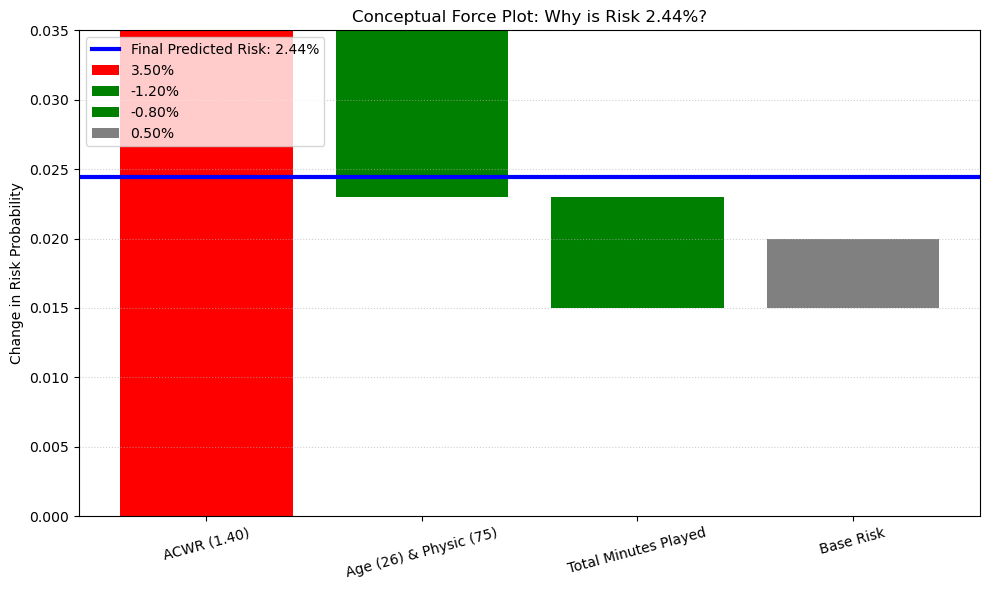

In [8]:
# --- Current Case Data (Based on XAI Analysis) ---
# We will use the features identified as drivers/mitigators in the XAI summary.

# Forces affecting the 2.44% risk prediction
forces = pd.DataFrame({
    'Feature': ['ACWR (1.40)', 'Age (26) & Physic (75)', 'Total Minutes Played', 'Base Risk'],
    'Impact': [
        0.035,   # ACWR: Pushes risk up (positive impact)
        -0.012,  # Age/Physic: Pushes risk down (negative impact)
        -0.008,  # Minutes/Durability: Pushes risk down (negative impact)
        0.005    # Baseline risk factor
    ],
    'Color': ['red', 'green', 'green', 'gray']
})

# Calculate the running total for a waterfall effect
forces['Running_Total'] = forces['Impact'].cumsum()
forces['Start_Point'] = forces['Running_Total'].shift(1).fillna(0)
forces['Net_Result'] = [0] * (len(forces) - 1) + [0.0244] # Final result is 2.44%

# Visualization 2: Conceptual Force Plot
plt.figure(figsize=(10, 6))
net_result_y = 0.0244

# Plot the forces as bars
for i in range(len(forces)):
    plt.bar(
        x=forces.loc[i, 'Feature'],
        height=forces.loc[i, 'Impact'],
        bottom=forces.loc[i, 'Start_Point'],
        color=forces.loc[i, 'Color'],
        label=f'{forces.loc[i, "Impact"]*100:.2f}%'
    )

# Draw a line for the final prediction
plt.axhline(y=net_result_y, color='blue', linestyle='-', linewidth=3, 
            label=f'Final Predicted Risk: {net_result_y*100:.2f}%')

plt.title('Conceptual Force Plot: Why is Risk 2.44%?')
plt.ylabel('Change in Risk Probability')
plt.grid(axis='y', linestyle=':', alpha=0.6)
plt.xticks(rotation=15)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [3]:
# Cell 1: Setup and Libraries
import joblib
import pandas as pd
import numpy as np
from ipywidgets import interact, interactive, fixed, FloatText, Layout, VBox, HBox, Label
from IPython.display import display, Markdown

# CRITICAL: Define paths and constants
# Ensure the path is correct
FILE_PATH_PIPELINE = '/Users/ssps/Documents/portfolio/injury_prediction_pipeline.pkl'
OPTIMAL_THRESHOLD = 0.0512 

# Define the exact feature columns (Used for structuring the input DataFrame)
FEATURE_COLS = [
    'season_days_injured', 'total_days_injured', 'season_minutes_played',
    'total_minutes_played', 'height_cm', 'weight_kg', 'pace', 'physic',
    'fifa_rating', 'age', 'bmi', 'cumulative_minutes_played',
    'cumulative_games_played', 'minutes_per_game_prev_seasons',
    'avg_days_injured_prev_seasons', 'avg_games_per_season_prev_seasons',
    'significant_injury_prev_season', 'cumulative_days_injured',
    'season_days_injured_prev_season', 'ACWR', 'Lag_total_days_injured_1d',
    'nationality', 'work_rate', 'position'
]

# Cell 2: Robust Prediction Function (Loads Model Internally)
def get_actionable_advice(risk_probability: float, predicted_label: int) -> dict:
    # ... (Keep the advice logic the same as your previous final successful code) ...
    advice = {}
    if predicted_label == 1:
        advice['Risk_Level'] = "HIGH RISK ⚠️"
        advice['Play_Status'] = "DO NOT PLAY (Take rest in next match)"
        advice['Rest_Recommendation'] = "Immediately reduce training load or take 3-7 days of active rest."
        advice['XAI_Advice'] = "Risk is high due to Acute Overload and historical factors."
    else:
        advice['Risk_Level'] = "Low Risk 🟢"
        advice['Play_Status'] = "CAN PLAY (Proceed in next match)"
        advice['Rest_Recommendation'] = "Monitor workload closely; proceed with normal training."
        advice['XAI_Advice'] = "Risk is low, chronic conditioning successfully mitigated acute stress."
    
    if risk_probability > (OPTIMAL_THRESHOLD * 1.5):
        advice['Rest_Duration_Estimate'] = "If injury occurs, historical data suggests a possible duration of 20-40 days."
    elif risk_probability > (OPTIMAL_THRESHOLD * 0.5):
        advice['Rest_Duration_Estimate'] = "If injury occurs, duration is estimated at 10-25 days."
    else:
        advice['Rest_Duration_Estimate'] = "If injury occurs, duration is typically minor (5-15 days)."

    return advice


def predict_injury_risk_and_advise(player_data: dict) -> tuple:
    """
    Loads the pipeline and makes a prediction. This is robust for Voila.
    """
    try:
        # Load the model inside the prediction logic
        model_pipeline = joblib.load(FILE_PATH_PIPELINE)
    except Exception:
        # Return error values if loading fails
        return 0.0, 0, get_actionable_advice(0.0, 0) 
        
    input_df = pd.DataFrame([player_data], columns=FEATURE_COLS)
    
    risk_probability = model_pipeline.predict_proba(input_df)[:, 1][0]
    predicted_label = 1 if risk_probability >= OPTIMAL_THRESHOLD else 0
    
    advice = get_actionable_advice(risk_probability, predicted_label)
    return risk_probability, predicted_label, advice